### Conduct raw data quality check - visual inspection

In [67]:
import os
import pickle as pkl
import sys
sys.path.append('/Users/kana/Library/Mobile Documents/com~apple~CloudDocs/Codes/GWOT_colorprefrencequalia')
import numpy as np
import pandas as pd
import sklearn
import csv
from scipy.stats import pearsonr, spearmanr
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import MDS
import seaborn as sns
import ot
import plotly.graph_objs as go
import plotly.express as px
from mpl_toolkits.axes_grid1 import make_axes_locatable
import utilityFunctions
print(sys.path)
from itertools import combinations

['/opt/anaconda3/envs/colorpreferencequalia/lib/python312.zip', '/opt/anaconda3/envs/colorpreferencequalia/lib/python3.12', '/opt/anaconda3/envs/colorpreferencequalia/lib/python3.12/lib-dynload', '', '/opt/anaconda3/envs/colorpreferencequalia/lib/python3.12/site-packages', '/opt/anaconda3/envs/colorpreferencequalia/lib/python3.12/site-packages/setuptools/_vendor', '/Users/kana/Library/Mobile Documents/com~apple~CloudDocs/Codes/GWOT_colorprefrencequalia', '/Users/kana/Library/Mobile Documents/com~apple~CloudDocs/Codes/GWOT_colorprefrencequalia', '/Users/kana/Library/Mobile Documents/com~apple~CloudDocs/Codes/GWOT_colorprefrencequalia', '/Users/kana/Library/Mobile Documents/com~apple~CloudDocs/Codes/GWOT_colorprefrencequalia', '/Users/kana/Library/Mobile Documents/com~apple~CloudDocs/Codes/GWOT_colorprefrencequalia']


In [65]:
# Define unique colors
unique_colours = np.array(['#d2b700', '#db8b08', '#c7512c', '#c13547', '#a03663', '#753a7a', '#4b488e', '#005692', '#006a8b', '#007b75', '#008a52', '#9aa400'])
colour_index = {colour: idx for idx, colour in enumerate(unique_colours)}
matrix_size = len(unique_colours)

### configuration
n_eps = 15 # number of epsilon values tried
eps_range = [0.04, 5] # the range of epsilon searched
epsilons = np.logspace(np.log10(eps_range[0]), np.log10(eps_range[1]), n_eps) # epsilon values

/var/folders/zk/lv_zrs9910s49_109vbgf6c40000gn/T/ipykernel_94685/1725088454.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['transformed_index'] = filtered_df['trials.thisIndex'].map(index_mapping)


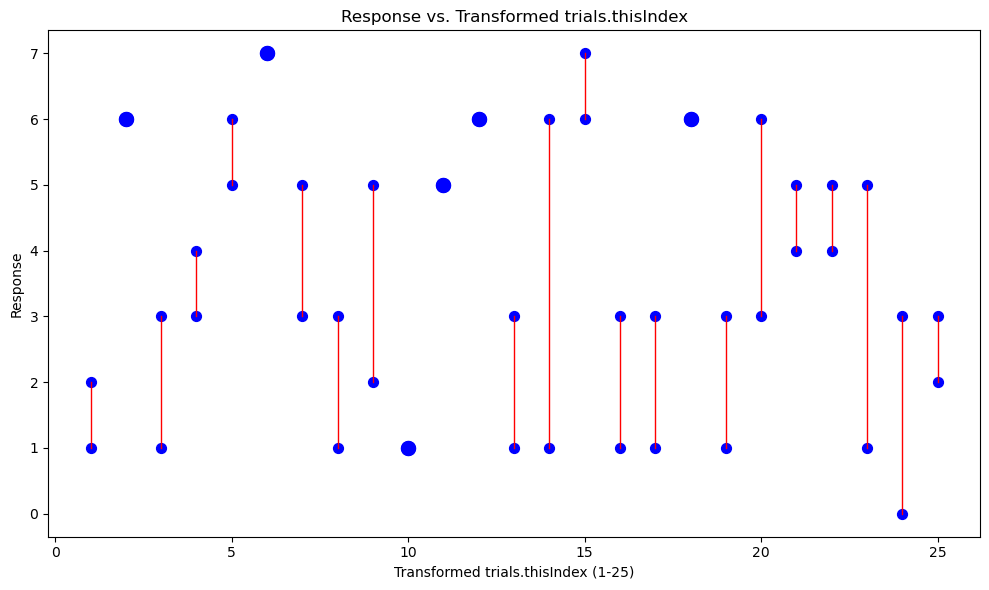

Overall Correlation: -0.1049030744560341


In [70]:
# 1. Read the CSV file
file_path = '/Users/kana/Library/Mobile Documents/com~apple~CloudDocs/Codes/GWOT_raw_data/202411_data/5a9b20c535237b0001129820_kana_colourPreferenceQualia_2024-11-14_03h40.27.980.csv' 
df = pd.read_csv(file_path)

# 2. Eliminate rows where practice_trial == 1
df = df[df['practice_trial'] != 1]

# 3. Filter rows where response_type == "similarity"
df = df[df['response_type'] == "similarity"]

# 4. Look at the first 25 pairs
# Get trials.thisIndex values for the first 25 rows
first_25_indices = df['trials.thisIndex'].iloc[:25].tolist()

# 5 & 6. Get all rows where trials.thisIndex matches one of the first 25 values
filtered_df = df[df['trials.thisIndex'].isin(first_25_indices)]

# Create a mapping of unique trials.thisIndex values to a sequential range
unique_indices = list(filtered_df['trials.thisIndex'].unique())[:25]  # Ensure only 25 unique values
index_mapping = {original: new for new, original in enumerate(unique_indices, start=1)}  # Map to 1-25

# Apply the mapping to transform trials.thisIndex into sequential range (1-25)
filtered_df['transformed_index'] = filtered_df['trials.thisIndex'].map(index_mapping)

# 7. Plot "response" value as the y-axis with the x-axis being the transformed indices
# Group the filtered dataframe by the transformed_index
grouped = filtered_df.groupby('transformed_index')

# Initialize the plot
plt.figure(figsize=(10, 6))

for transformed_index, group in grouped:
    x = [transformed_index] * len(group)  # Transformed index as x-axis values
    y = group['response'].tolist()  # Response values as y-axis values
    
    # Check if y-values are identical for the given x-value
    identical_y_values = len(set(y)) == 1
    
    # Set scatter size: double the size if y-values are identical, default otherwise
    scatter_size = 100 if identical_y_values else 50 
    
    # Scatter plot the points
    plt.scatter(x, y, color='blue', s=scatter_size)
    
    # 8 & 9. Connect the two y values with a line if there are two rows per x value
    if len(y) == 2:
        plt.plot([transformed_index, transformed_index], y, color='red', linewidth=1)  # Connect the points with a line

# Label axes
plt.xlabel('Transformed trials.thisIndex (1-25)')
plt.ylabel('Response')
plt.title('Response vs. Transformed trials.thisIndex')

# Show the plot
plt.tight_layout()
plt.show()

# Calculate the general correlation between 'transformed_index' and 'response'
overall_correlation = filtered_df['transformed_index'].corr(filtered_df['response'])

# Print the result
print("Overall Correlation:", overall_correlation)


In [78]:
def process_csv(file_path):
    df = pd.read_csv(file_path)
    
    # Step 2: Eliminate rows where practice_trial == 1
    df = df[df['practice_trial'] != 1]
    
    # Step 3: Filter rows where response_type == "similarity"
    df = df[df['response_type'] == "similarity"]
    
    # Step 4: Look at the first 25 trials.thisIndex values
    first_25_indices = df['trials.thisIndex'].iloc[:25].tolist()
    
    # Step 5 & 6: Filter and map trials.thisIndex to sequential range
    filtered_df = df[df['trials.thisIndex'].isin(first_25_indices)]
    unique_indices = list(filtered_df['trials.thisIndex'].unique())[:25]
    index_mapping = {original: new for new, original in enumerate(unique_indices, start=1)}
    filtered_df['transformed_index'] = filtered_df['trials.thisIndex'].map(index_mapping)
    
    # Step 7: Set up the plot
    grouped = filtered_df.groupby('transformed_index')
    plt.figure(figsize=(10, 6))
    
    for transformed_index, group in grouped:
        x = [transformed_index] * len(group)
        y = group['response'].tolist()
        
        # Check for identical y-values and set scatter size
        identical_y_values = len(set(y)) == 1
        scatter_size = 100 if identical_y_values else 50
        
        # Plot scatter points
        plt.scatter(x, y, color='blue', s=scatter_size)
        
        # Step 8 & 9: Plot connection between points if there are two rows per x
        if len(y) == 2:
            plt.plot([transformed_index, transformed_index], y, color='red', linewidth=1)
    
    plt.xlabel('Transformed trials.thisIndex (1-25)')
    plt.ylabel('Response')
    plt.title('Response vs. Transformed trials.thisIndex')
    
    # Calculate overall correlation
    overall_correlation = filtered_df['transformed_index'].corr(filtered_df['response'])
    
    # Display correlation in a textbox
    plt.text(
        max(filtered_df['transformed_index']) * 0.95,
        max(filtered_df['response']) * 0.95,
        f"Overall Correlation: {overall_correlation:.2f}",
        fontsize=10,
        verticalalignment='top',
        horizontalalignment='right',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    )
    
    # Save plot as PNG
    plt.tight_layout()
    plt.show()

/var/folders/zk/lv_zrs9910s49_109vbgf6c40000gn/T/ipykernel_94685/2061933395.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['transformed_index'] = filtered_df['trials.thisIndex'].map(index_mapping)


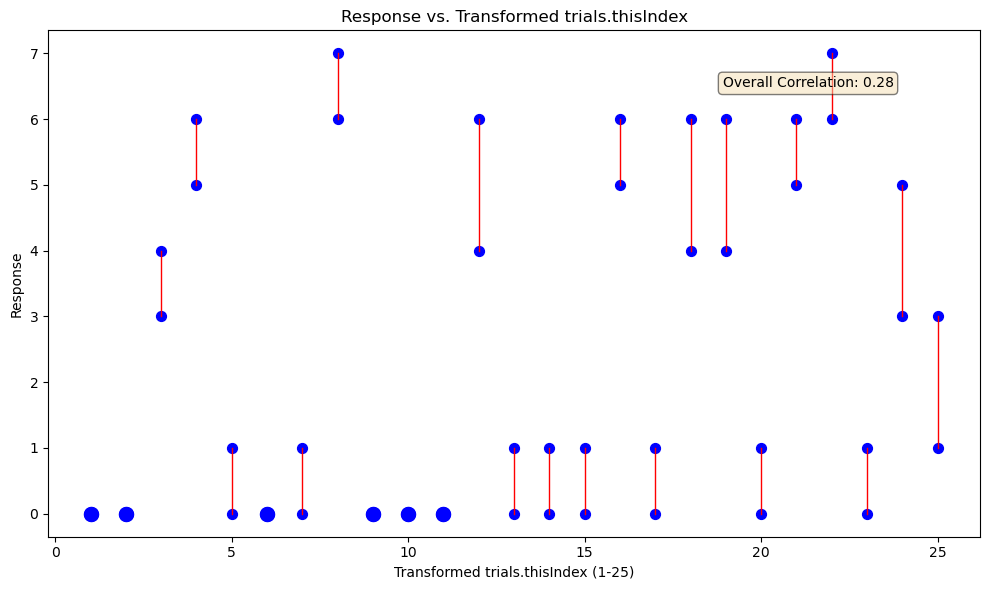

/var/folders/zk/lv_zrs9910s49_109vbgf6c40000gn/T/ipykernel_94685/2061933395.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['transformed_index'] = filtered_df['trials.thisIndex'].map(index_mapping)


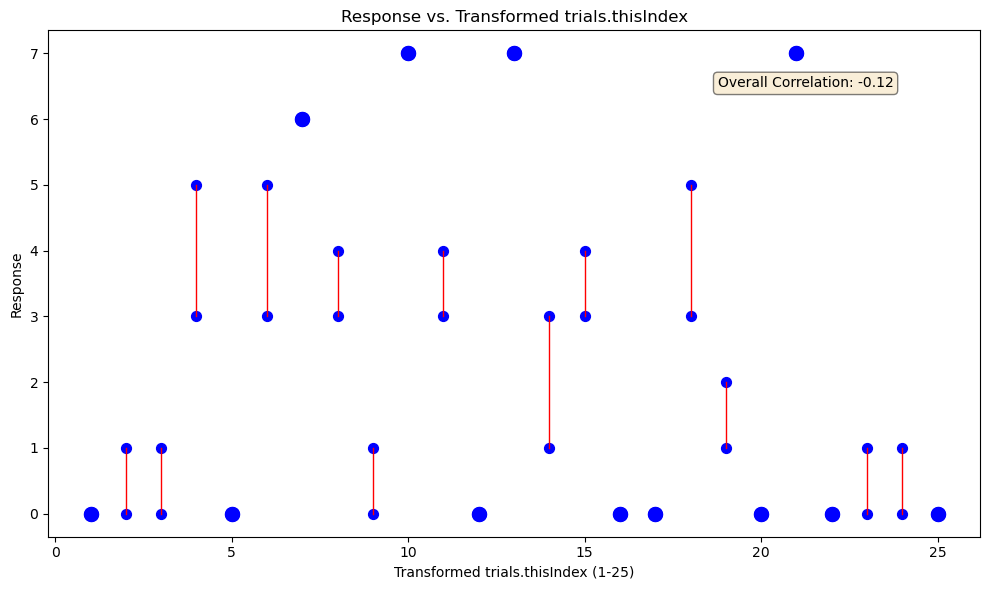

/var/folders/zk/lv_zrs9910s49_109vbgf6c40000gn/T/ipykernel_94685/2061933395.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['transformed_index'] = filtered_df['trials.thisIndex'].map(index_mapping)


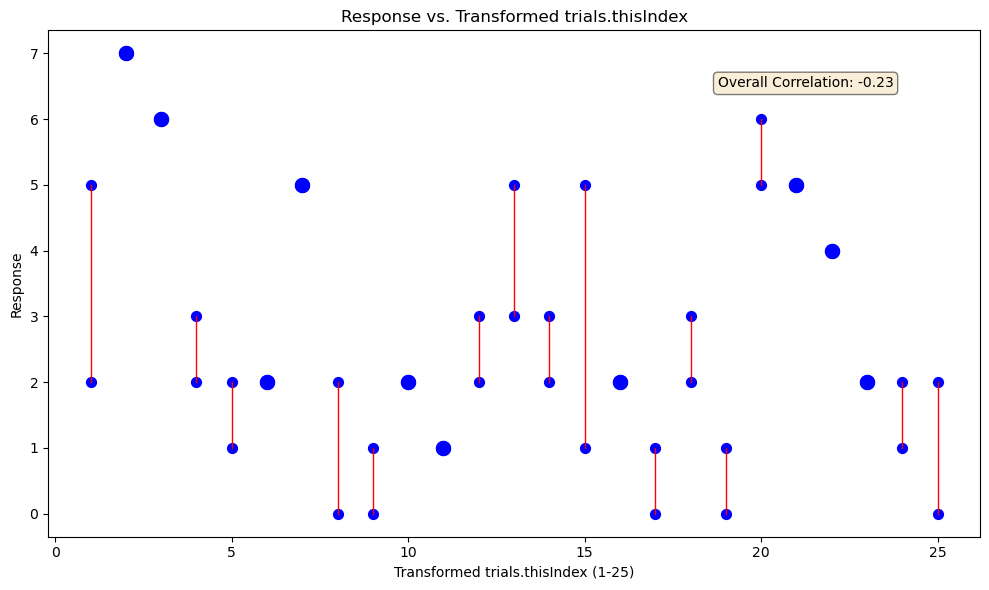

/var/folders/zk/lv_zrs9910s49_109vbgf6c40000gn/T/ipykernel_94685/2061933395.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['transformed_index'] = filtered_df['trials.thisIndex'].map(index_mapping)


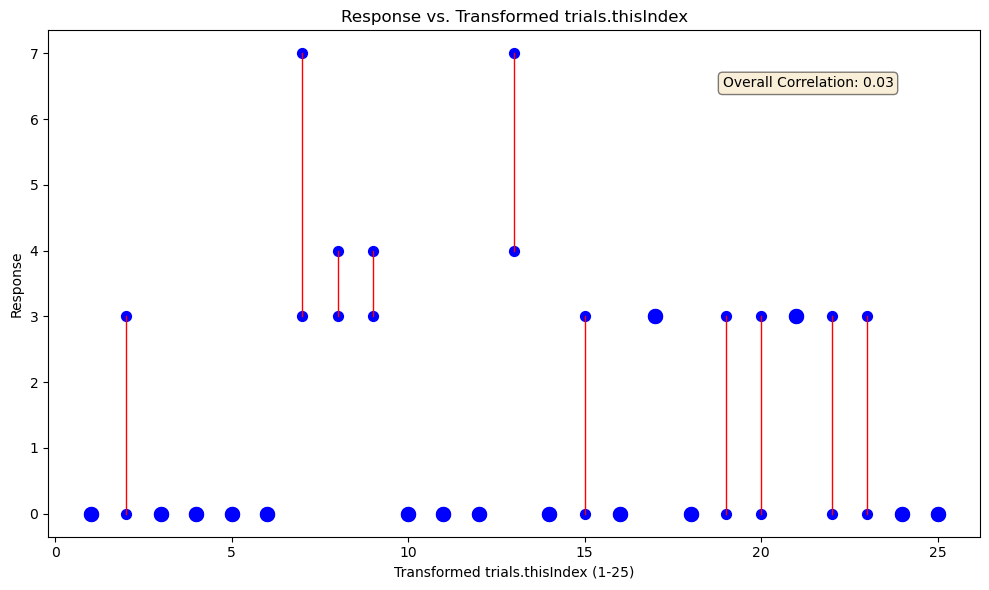

/var/folders/zk/lv_zrs9910s49_109vbgf6c40000gn/T/ipykernel_94685/2061933395.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['transformed_index'] = filtered_df['trials.thisIndex'].map(index_mapping)


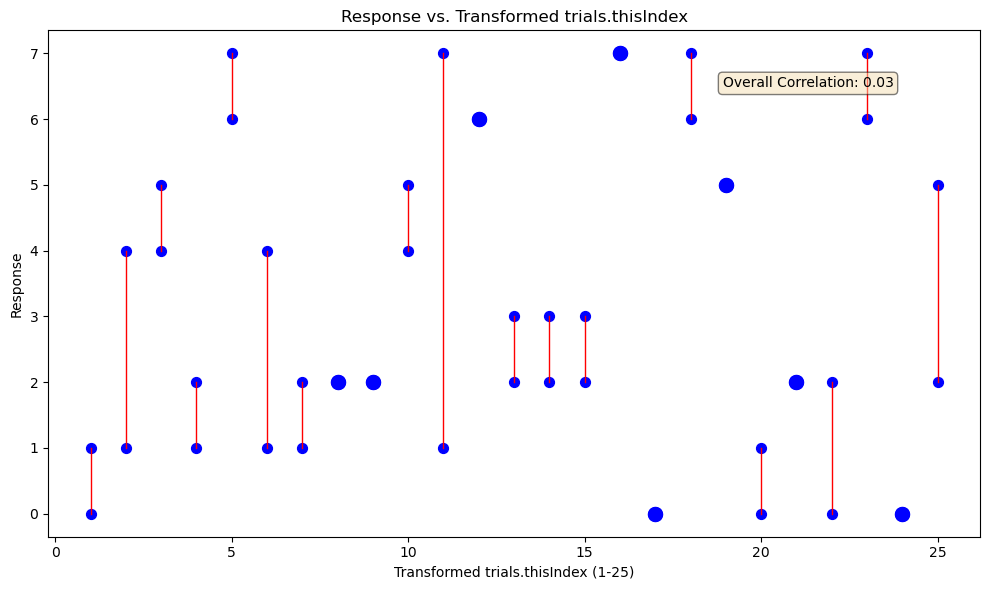

/var/folders/zk/lv_zrs9910s49_109vbgf6c40000gn/T/ipykernel_94685/2061933395.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['transformed_index'] = filtered_df['trials.thisIndex'].map(index_mapping)


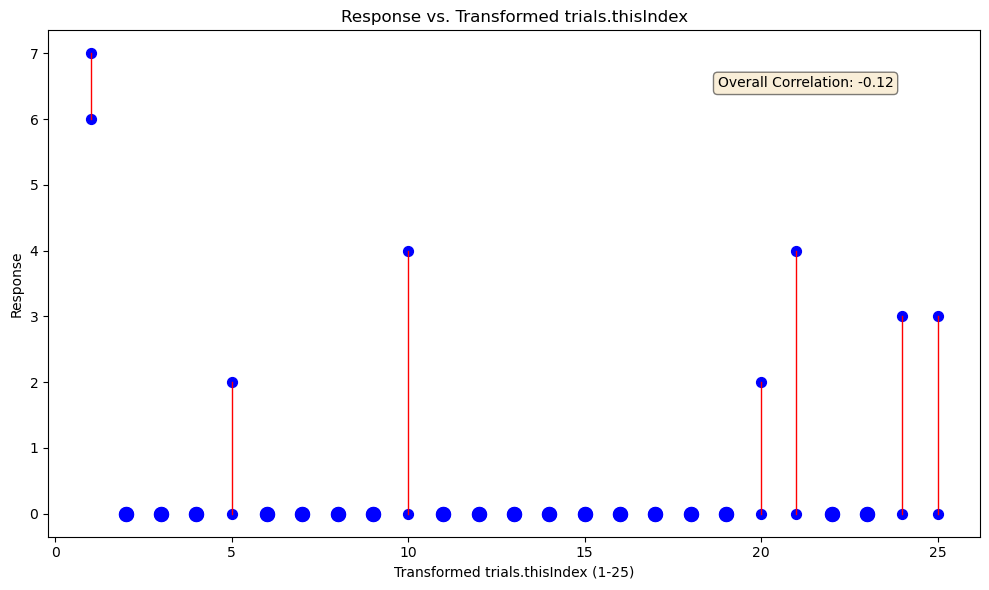

/var/folders/zk/lv_zrs9910s49_109vbgf6c40000gn/T/ipykernel_94685/2061933395.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['transformed_index'] = filtered_df['trials.thisIndex'].map(index_mapping)


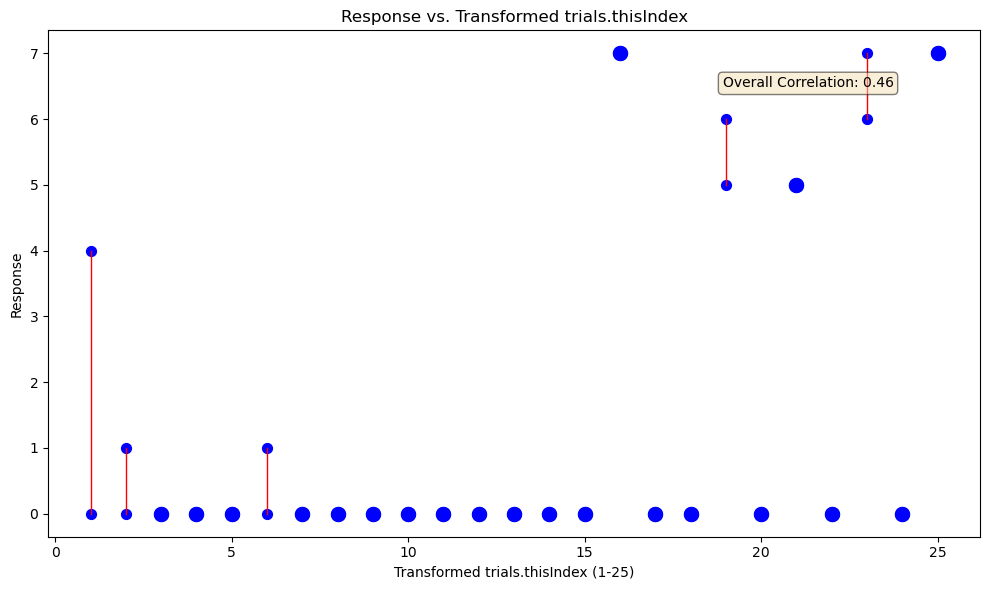

/var/folders/zk/lv_zrs9910s49_109vbgf6c40000gn/T/ipykernel_94685/2061933395.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['transformed_index'] = filtered_df['trials.thisIndex'].map(index_mapping)


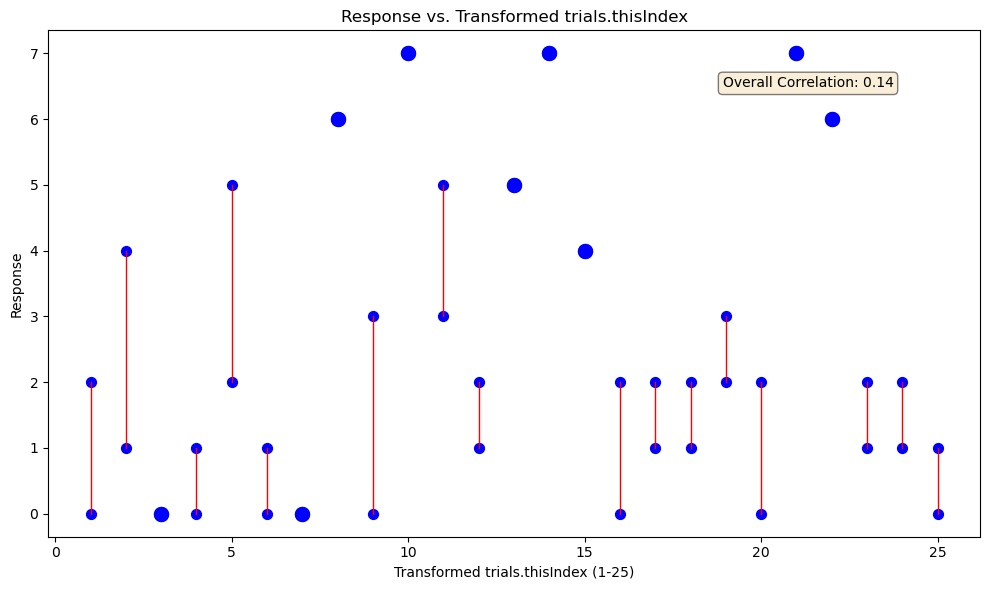

/var/folders/zk/lv_zrs9910s49_109vbgf6c40000gn/T/ipykernel_94685/2061933395.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['transformed_index'] = filtered_df['trials.thisIndex'].map(index_mapping)


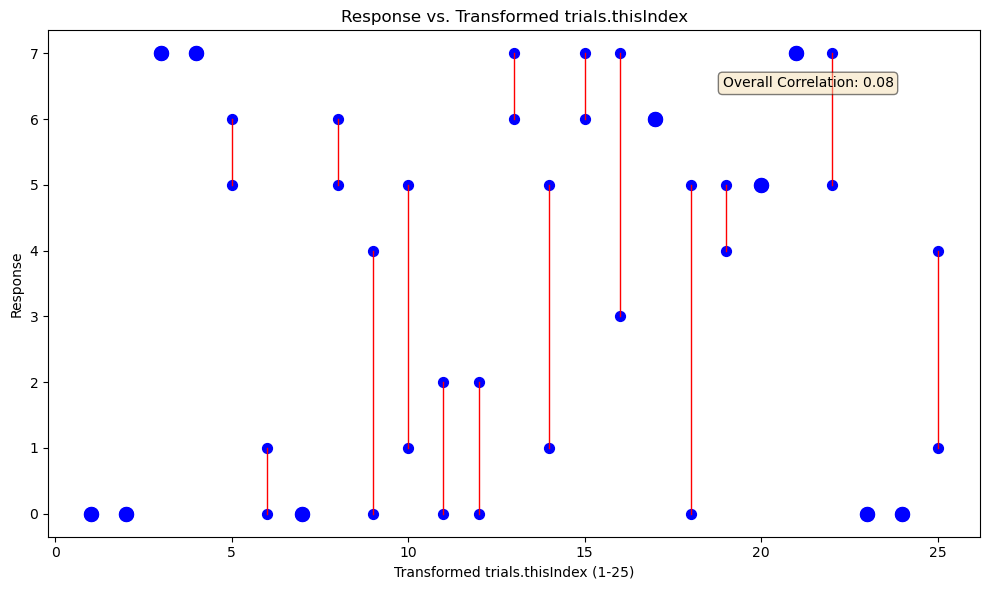

/var/folders/zk/lv_zrs9910s49_109vbgf6c40000gn/T/ipykernel_94685/2061933395.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['transformed_index'] = filtered_df['trials.thisIndex'].map(index_mapping)


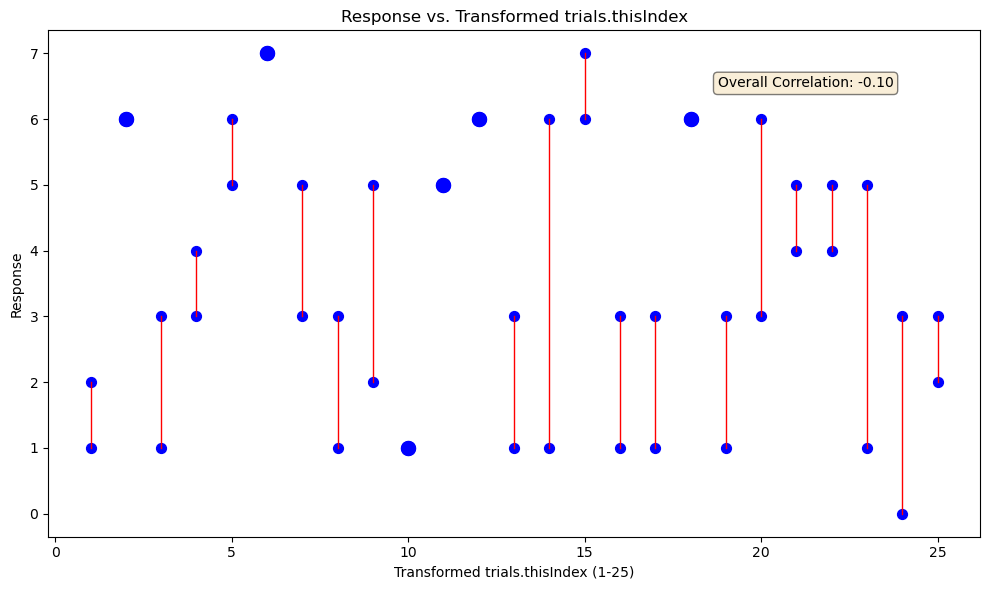

/var/folders/zk/lv_zrs9910s49_109vbgf6c40000gn/T/ipykernel_94685/2061933395.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['transformed_index'] = filtered_df['trials.thisIndex'].map(index_mapping)


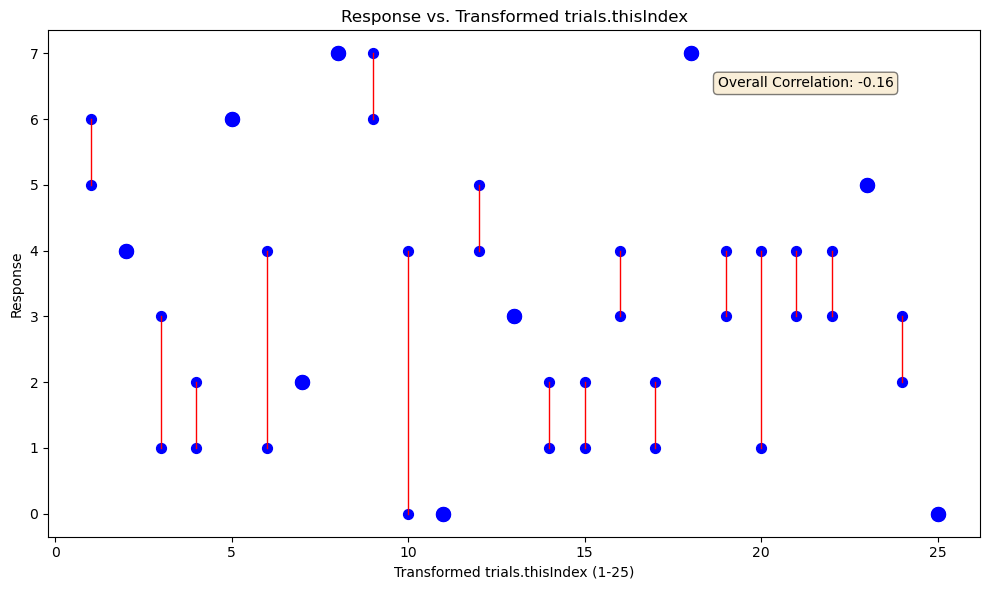

/var/folders/zk/lv_zrs9910s49_109vbgf6c40000gn/T/ipykernel_94685/2061933395.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['transformed_index'] = filtered_df['trials.thisIndex'].map(index_mapping)


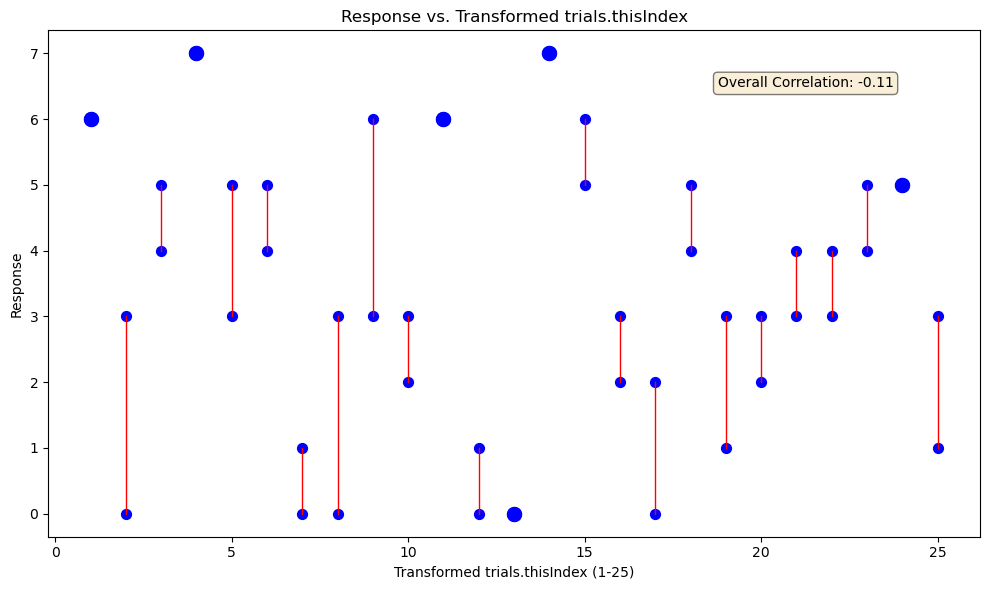

/var/folders/zk/lv_zrs9910s49_109vbgf6c40000gn/T/ipykernel_94685/2061933395.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['transformed_index'] = filtered_df['trials.thisIndex'].map(index_mapping)


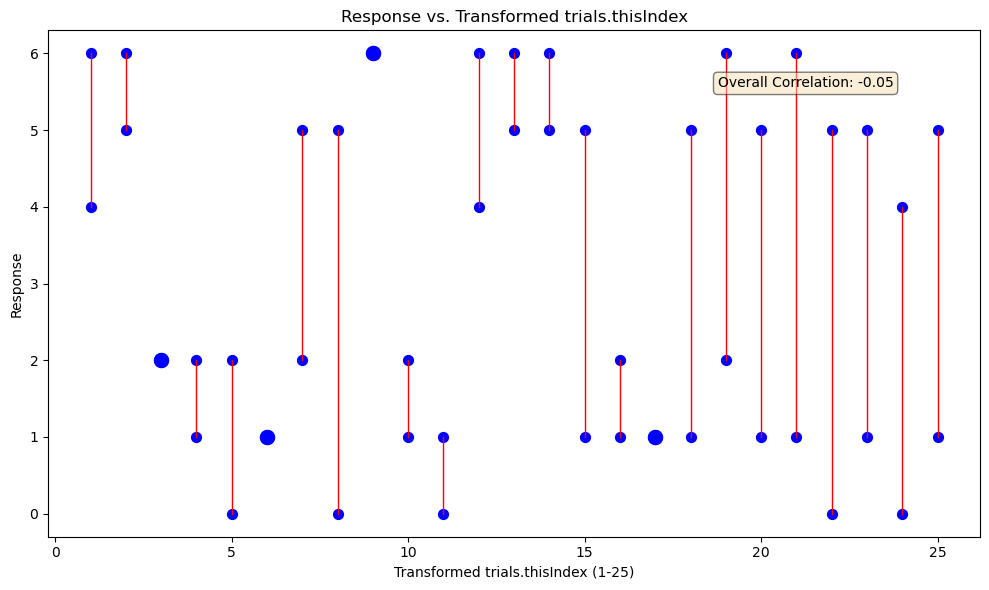

/var/folders/zk/lv_zrs9910s49_109vbgf6c40000gn/T/ipykernel_94685/2061933395.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['transformed_index'] = filtered_df['trials.thisIndex'].map(index_mapping)


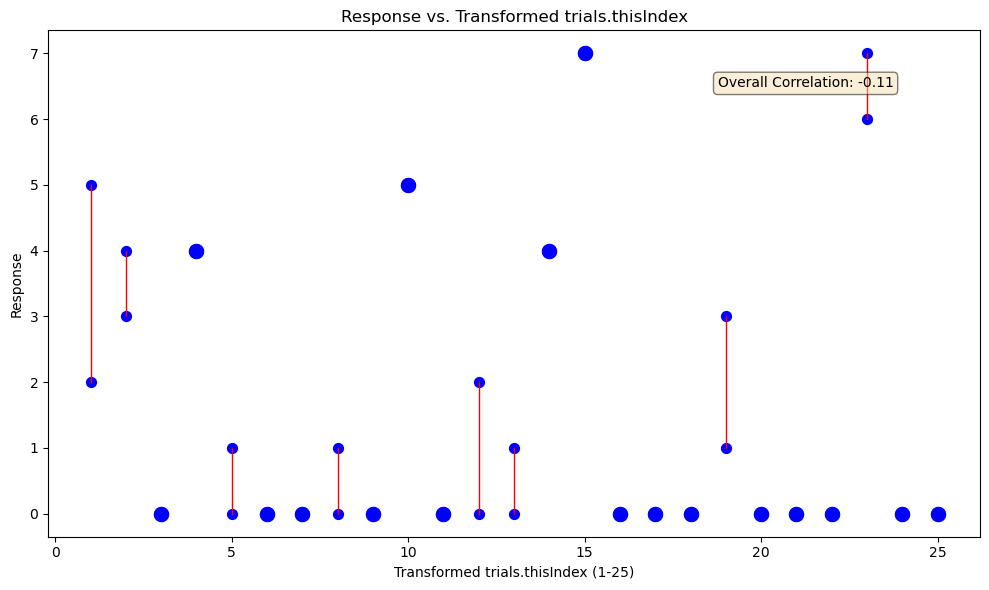

/var/folders/zk/lv_zrs9910s49_109vbgf6c40000gn/T/ipykernel_94685/2061933395.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['transformed_index'] = filtered_df['trials.thisIndex'].map(index_mapping)


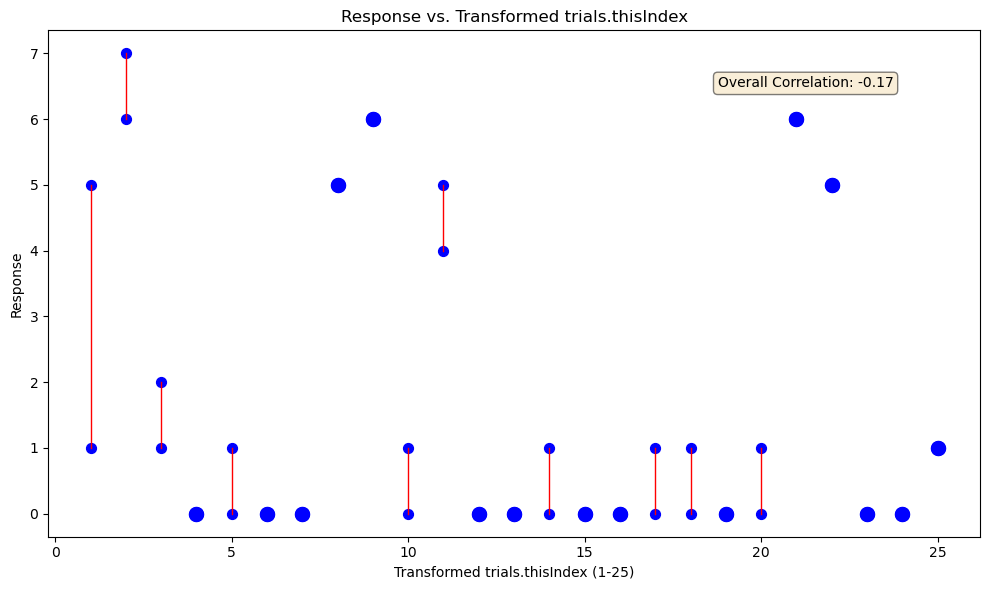

/var/folders/zk/lv_zrs9910s49_109vbgf6c40000gn/T/ipykernel_94685/2061933395.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['transformed_index'] = filtered_df['trials.thisIndex'].map(index_mapping)


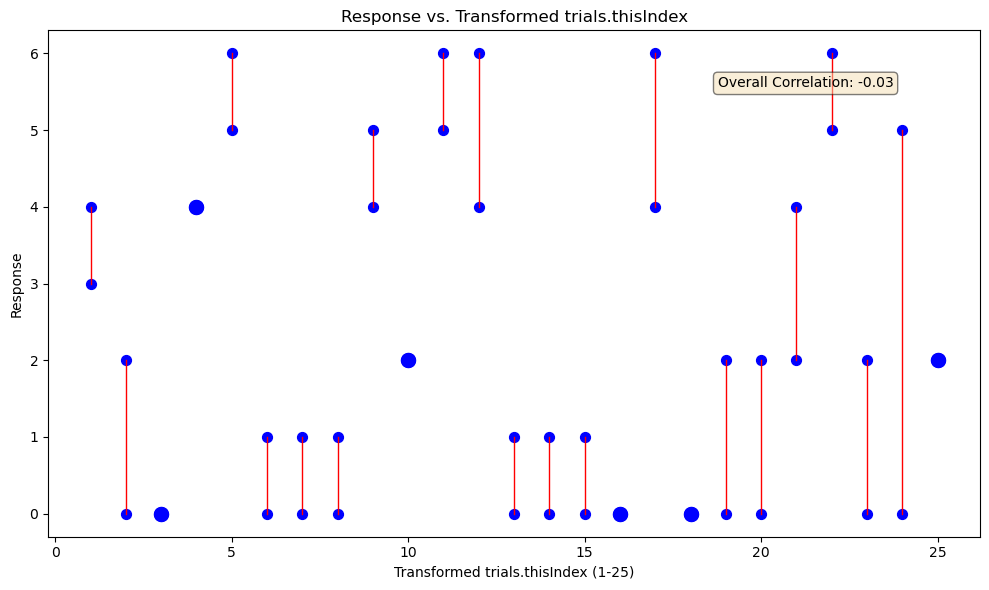

/var/folders/zk/lv_zrs9910s49_109vbgf6c40000gn/T/ipykernel_94685/2061933395.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['transformed_index'] = filtered_df['trials.thisIndex'].map(index_mapping)


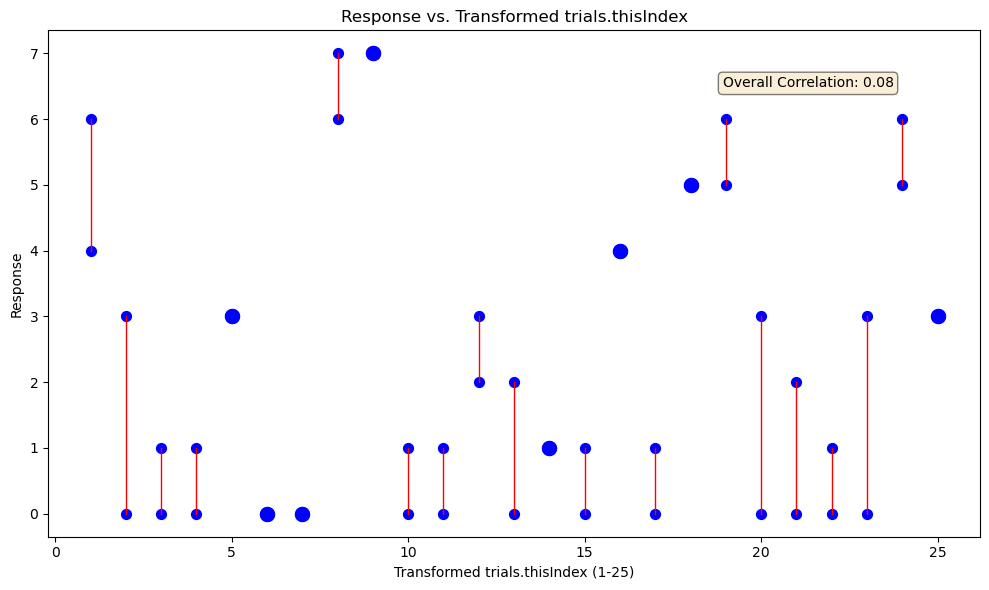

/var/folders/zk/lv_zrs9910s49_109vbgf6c40000gn/T/ipykernel_94685/2061933395.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['transformed_index'] = filtered_df['trials.thisIndex'].map(index_mapping)


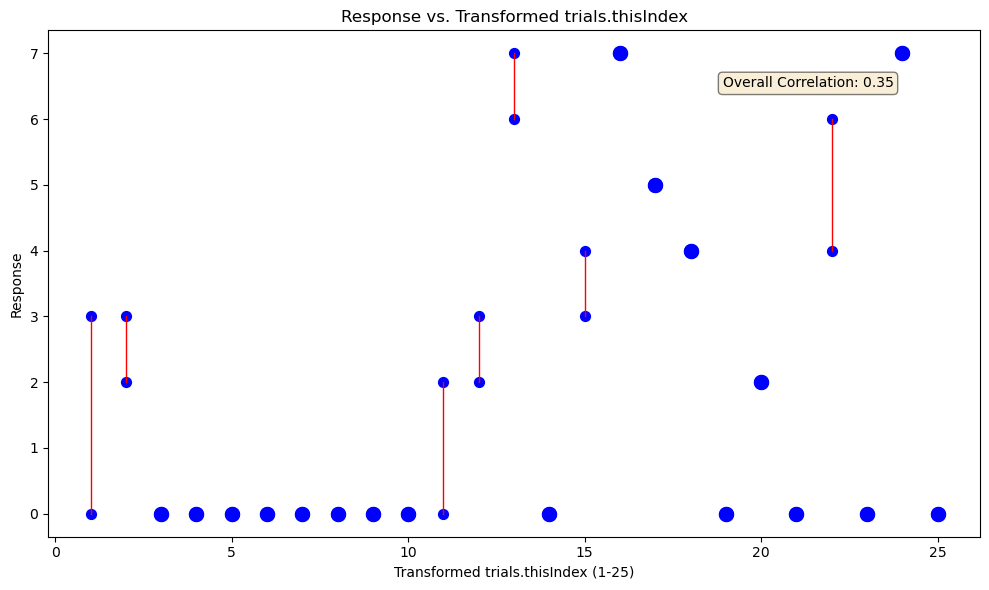

/var/folders/zk/lv_zrs9910s49_109vbgf6c40000gn/T/ipykernel_94685/2061933395.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['transformed_index'] = filtered_df['trials.thisIndex'].map(index_mapping)


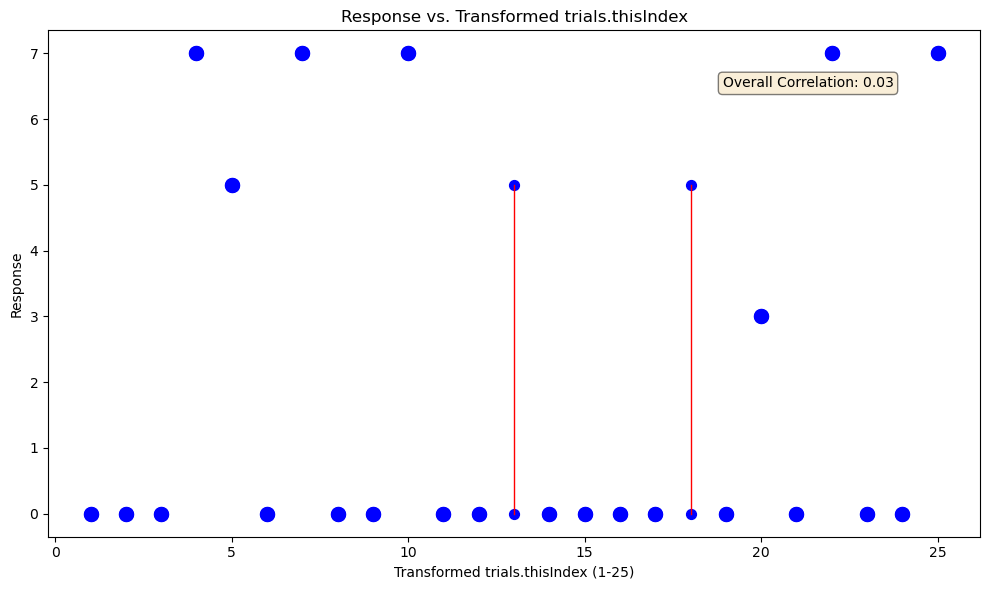

In [79]:
# Process all CSV files in the specified folder
folder_path = '/Users/kana/Library/Mobile Documents/com~apple~CloudDocs/Codes/GWOT_raw_data/202411_data'
for filename in os.listdir(folder_path):
    if filename.endswith('.csv'):
        file_path = os.path.join(folder_path, filename)
        process_csv(file_path)